# (1) 필요 모듈 불러오기

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
print("🌫🛸")

🌫🛸


In [2]:
import dlib
detector_hog = dlib.get_frontal_face_detector()   #- detector 선언
print("🌫🛸")

🌫🛸


# (2) 이미지 준비하기

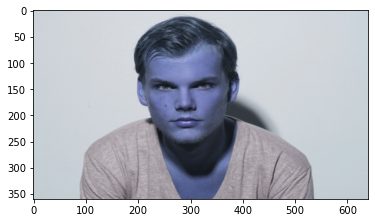

In [3]:
import os
my_image_path = os.getenv('HOME')+'/aiffel/Exploration_3/camera_sticker/images/image.jpg'
img_bgr = cv2.imread(my_image_path)    #- OpenCV로 이미지를 읽어서
img_bgr = cv2.resize(img_bgr, (640, 360))    # 640x360의 크기로 Resize
img_show = img_bgr.copy()      #- 출력용 이미지 별도 보관
plt.imshow(img_bgr)
plt.show()

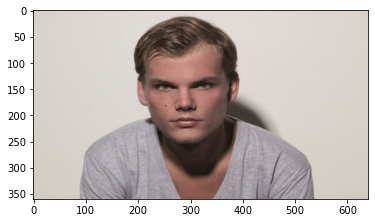

In [4]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB) #cvtColor함수는 convert color인것같다
plt.imshow(img_rgb)
plt.show()

# (2) bounding box 추출

In [5]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)   #- (image, num of img pyramid)
print("🌫🛸")

🌫🛸


rectangles[[(218, 98) (373, 253)]]


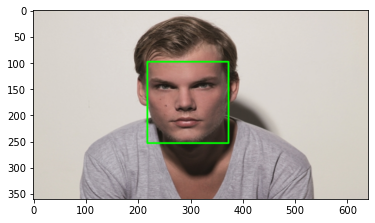

In [6]:
print(dlib_rects)   # 찾은 얼굴영역 좌표

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)
                #(Image,    start,   end,   color  , thickness, line type  )

    
img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

# (3) Landmark 모델 불러오기

In [7]:
import os
model_path = os.getenv('HOME')+'/aiffel/Exploration_3/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)
print("🌫🛸")

🌫🛸


In [8]:
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

68


# (4) Landmark 출력

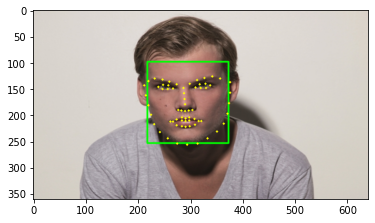

In [9]:
for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

# (5) 좌표 확인

In [10]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print ("코 끝", landmark[33]) # nose end: 33
    x = landmark[33][0]
    y = landmark[33][1] 
    w = dlib_rect.width()
    h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

코 끝 (290, 192)
(x,y) : (290,192)
(w,h) : (156,156)


## 고양이 코 스티커는 코 끝에 위치해야하기때문에 33번 landmark로 지정

## 위 결과값을 설명하자면:

![coordinates](https://user-images.githubusercontent.com/74899925/104759050-aa650e00-57a2-11eb-967e-eee46f85bde5.png)


### 1. 코 끝: landmark[33]의 위치는 x축의 290, y축의 192에 위치한다
### 2. 스티커가 시작될 위치는 (x,y) : (290,192)로 스티커 이미지의 top-left corner가 모델의 코 끝(290,192)에서 시작된다는 것이다.
### 3. Bounding Box의 크기는 156 x 156

### 그러므로 스티커 이미지를 Bounding Box이미지의 사이즈와 동일하게 만든뒤 x축으로 -w/2만큼, Y축으로 y만큼 이동시켜야한다

# (6) 스티커 resize

(156, 156, 3)


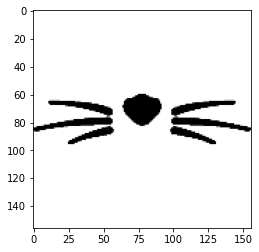

In [11]:
import os
sticker_path = os.getenv('HOME')+'/aiffel/Exploration_3/camera_sticker/images/cat-whiskers.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h))
print (img_sticker.shape)
plt.imshow(img_sticker)

### ↳ Boarderline에 맞춰 156 x 156으로 조정하였다.

# (7) 스티커 시작점 좌표 재갱신

## 이미지 크기를 똑같이 맞췄으니, 스티커가 Bounding Box를 덮어씌울수있게 좌표를 재갱신 해줘야한다.
## 스티커와 Bounding Box의 top-left corner를 일치시키면 완벽히 덮어씌울 수 있다.

In [12]:
refined_x = x - w // 2  # left 
refined_y = 98      # top
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (212,98)


### ↳ 스티커의 top-left corner의 좌표를 재갱신해주었다.
### ↳ x는 -w/2만큼 이동시켜주면 되지만, y는 이미지 모델의 얼굴 비율에 따라 이동을 해줘야하기때문에 시작점을 98로 지정해주었다.

# (8) 스티커 붙일 영역 지정

## 위를 하고난뒤 현재 스티커의 시작 좌표가 Bounding Box의 top-left corner와 일치한다. 
## 이후엔 아래와 같이 Box의 height와 width만큼 스티커를 붙일 영역을 지정해줘야한다

![coordinates_2](https://user-images.githubusercontent.com/74899925/104760534-d97c7f00-57a4-11eb-9d01-391d5447af83.png)

In [13]:
#스티커 이미지의 bottom-left Y좌표
img_sticker_h = refined_y +img_sticker.shape[0]
img_sticker_h

254

In [14]:
#스티커 이미지의 top_right X좌표
img_sticker_w = refined_x +img_sticker.shape[1]
img_sticker_w

368

## 시작 좌표와 끝 좌표 Indexing을 통해 스티커를 붙일 영역을 지정한다.

In [15]:
sticker_area = img_show[refined_y:img_sticker_h, refined_x:img_sticker_w]
# 스티커를 붙일 이미지 영역 = 파란사진[98좌표에서 254좌표까지, 212좌표에서 368좌표까지 ]
img_show[refined_y:img_sticker_h, refined_x:img_sticker_w] = \
    np.where(img_sticker==0,img_sticker,sticker_area).astype(np.uint8)
            #img_sticker가 0이면 sticker_area픽셀을 유지하고 아니면 img_sticker의 픽셀로 대체하라

## 시행착오:
### np.where함수에서 `a = np.where(a=0,b,a)` 라면 "a가 0일경우 b로 대체하고 0이 아닐경우 a를 유지하라" 라는 뜻인데
### 어째서인지 `np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)`로 실행을 하면 아래와 같이 스티커가 반전돼서 출력됐다.

![reversed](https://user-images.githubusercontent.com/74899925/104746632-e6907280-5792-11eb-8882-3a4c38d46a78.png)


### 한참을 고생하다가 찾은 답은 위의 코드가 a = np.where(a=0, b, a) 형식이 아니기 때문이였다.
### 위 코드는 b = np.where(a=0, b, a) 형식이기때문에 반전이 일어난것같다.

# (9) 이미지 확인

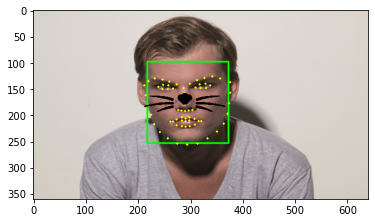

In [16]:
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

### ↳ 스티커가 잘 안착되었다.

# (10) Bounding Box 및 Landmark 제거

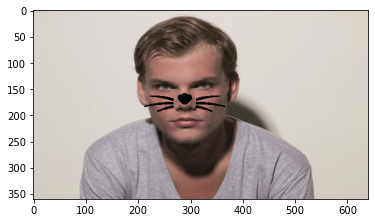

In [17]:
sticker_area = img_bgr[refined_y:img_sticker_h, refined_x:img_sticker_w]
img_bgr[refined_y:img_sticker_h, refined_x:img_sticker_w] = \
    np.where(img_sticker==0,img_sticker,sticker_area).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

### ↳ 드디어 완성됐다.

# ##다른 이미지에 적용하기

##  #측면 얼굴 인식

# (1) 이미지 준비

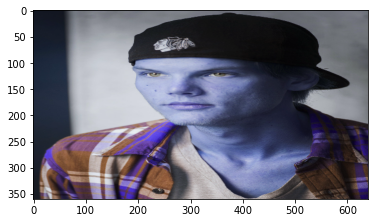

In [18]:
import os
my_image_path = os.getenv('HOME')+'/aiffel/Exploration_3/camera_sticker/images/image2.jpg'
img_bgr = cv2.imread(my_image_path)    
img_bgr = cv2.resize(img_bgr, (640, 360))  
img_show= img_bgr.copy()   
plt.imshow(img_bgr)
plt.show()

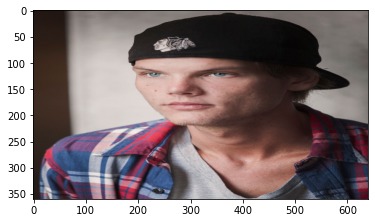

In [19]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB) #cvtColor함수는 convert color인것같다
plt.imshow(img_rgb)
plt.show()

# (2) Bounding Box 추출

In [20]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)   #- (image, num of img pyramid)
print("🌫🛸")

🌫🛸


rectangles[]


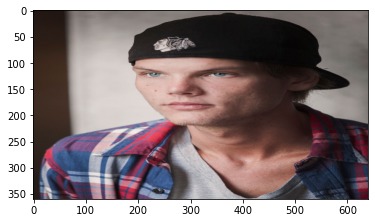

In [21]:
print(dlib_rects)   # 찾은 얼굴영역 좌표

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)
                #(Image,    start,   end,   color  , thickness, line type  )

    
img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

### ↳ 인식이 되지 않는다.

## #멀리서 찍은 사진 인식

## (1) 이미지 준비

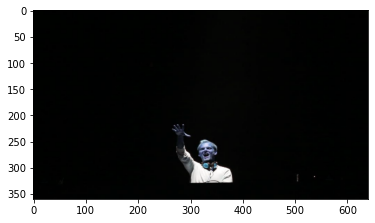

In [22]:
my_image_path = os.getenv('HOME')+'/aiffel/Exploration_3/camera_sticker/images/image_3.jpg'
img_bgr = cv2.imread(my_image_path)    
img_bgr = cv2.resize(img_bgr, (640, 360))  
img_show= img_bgr.copy()   
plt.imshow(img_bgr)
plt.show()

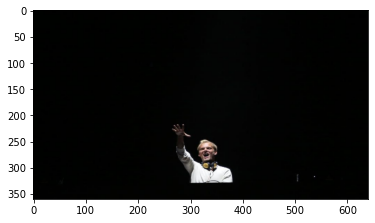

In [23]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB) #cvtColor함수는 convert color인것같다
plt.imshow(img_rgb)
plt.show()

## (2) Bounding Box 추출

In [24]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)   #- (image, num of img pyramid)
print("🌫🛸")

🌫🛸


rectangles[]


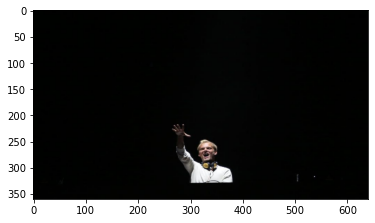

In [25]:
print(dlib_rects)   # 찾은 얼굴영역 좌표

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)
                #(Image,    start,   end,   color  , thickness, line type  )

    
img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

### ↳ 멀리서 찍은 사진 역시 인식이 되지 않는다.

## #또다른 각도

## (1) 이미지 준비

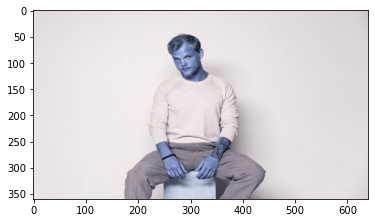

In [54]:
import os
my_image_path = os.getenv('HOME')+'/aiffel/Exploration_3/camera_sticker/images/image_4.jpg'
img_bgr = cv2.imread(my_image_path)    
img_bgr = cv2.resize(img_bgr, (640, 360))  
img_show= img_bgr.copy()   
plt.imshow(img_bgr)
plt.show()

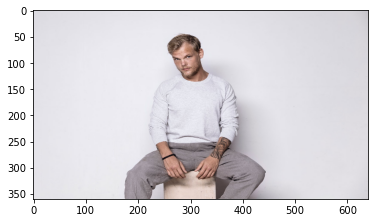

In [55]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB) #cvtColor함수는 convert color인것같다
plt.imshow(img_rgb)
plt.show()

## (2) Bounding Box 추출

In [56]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)   #- (image, num of img pyramid)
print("🌫🛸")

🌫🛸


rectangles[[(262, 72) (314, 124)]]


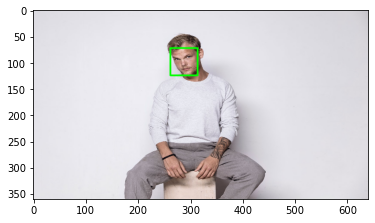

In [57]:
print(dlib_rects)   # 찾은 얼굴영역 좌표

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)
                #(Image,    start,   end,   color  , thickness, line type  )

    
img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

### ↳ 다른각도이지만 인식이된다

## (3) Landmark 불러오기

In [58]:
import os
model_path = os.getenv('HOME')+'/aiffel/Exploration_3/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)
print("🌫🛸")

🌫🛸


In [59]:
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

68


## (4) Landmark 추출

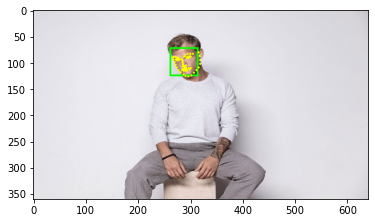

In [60]:
for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

### ↳ 정면사진과 비교했을때 Landmark의 분포도가 얼굴 각도에 따라 변했다.

## (5) 좌표 확인

In [61]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print ("코 끝", landmark[33]) # nose end: 33
    x = landmark[33][0]
    y = landmark[33][1] 
    w = dlib_rect.width()
    h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

코 끝 (288, 107)
(x,y) : (288,107)
(w,h) : (53,53)


## (6) 스티커 Resize

(53, 53, 3)


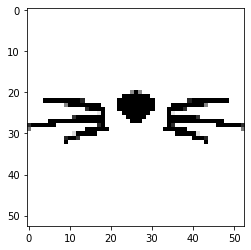

In [62]:
import os
sticker_path = os.getenv('HOME')+'/aiffel/Exploration_3/camera_sticker/images/cat-whiskers.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h))
print (img_sticker.shape)
plt.imshow(img_sticker)

## (7) 스티커 시작점 재갱신

In [63]:
refined_x = 262  # left 
refined_y = 80      # top
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (262,80)


### ↳ 정면사진과 얼굴 각도가 다르기때문에 스티커 시작점을 Bounding Box의 top-left corner보다 Y축으로 약간 낮은 좌표로 지정해주었다.

## (8) 스티커 붙일 영역 지정

In [64]:
#스티커 이미지의 bottom-left Y좌표
img_sticker_h = refined_y +img_sticker.shape[0]
img_sticker_h

133

In [65]:
#스티커 이미지의 top_right X좌표
img_sticker_w = refined_x +img_sticker.shape[1]
img_sticker_w

315

In [66]:
sticker_area = img_show[refined_y:img_sticker_h, refined_x:img_sticker_w]
# 스티커를 붙일 이미지 영역 = 파란사진[98좌표에서 254좌표까지, 212좌표에서 368좌표까지 ]
img_show[refined_y:img_sticker_h, refined_x:img_sticker_w] = \
    np.where(img_sticker==0,img_sticker,sticker_area).astype(np.uint8)
            #img_sticker가 0이면 sticker_area픽셀을 유지하고 아니면 img_sticker의 픽셀로 대체하라

## (9) 이미지 확인

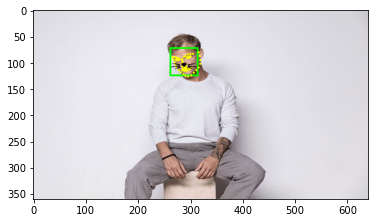

In [67]:
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

## (10) Landmark 및 Bounding Box 제거

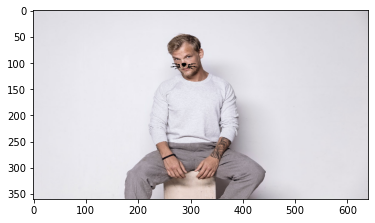

In [69]:
sticker_area = img_bgr[refined_y:img_sticker_h, refined_x:img_sticker_w]
img_bgr[refined_y:img_sticker_h, refined_x:img_sticker_w] = \
    np.where(img_sticker==0,img_sticker,sticker_area).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

### ↳ 스티커는 잘 안착되었지만 각도의 변화는 없다.

# ###문제점 찾아보기

---

## (1) 얼굴 각도에 따라 스티커가 어떻게 변해야할까요?

### 위처럼 얼굴 각도가 달라지면서 Landmark의 분포비율도 달라지지만, 스티커에대한 비율 변화를 가져오진 않았다.
### ↳ 위의 현상을 해결하기위해 2가지 방법을 사용해야할것 같다:
### 1. 3D wrap을 이용하여 모델 이미지를 allign하여 landmark 추출
### 2. 3D wrap을 이용하여 스티커사진 변형

## (2) 멀리서 촬영하면 왜 안될까요? 옆으로 누워서 촬영하면 왜 안될까요?

### 멀리서 촬영한 사진과 측면 사진을 이용해봤는데 hog detector는 둘다 인식을 하지 못했다.

### Hog detector의 데이터에 기반한 문제가 가장 큰것 같다. Hog Detector는 여러 이미지의 데이터를 모아 아래와 같은 gradient pattern을 얼굴이라 인식한다.

![hog_detector](https://user-images.githubusercontent.com/74899925/104842802-83c1e700-590a-11eb-9eeb-7dacba518155.png)

### 즉, Hog Detector가 얼굴을 인식하기위해선 이미지 모델의 패턴또한 Hog Detector가 가지고 있는 패턴과 유사해야 한다는 뜻이다. 하지만 옆으로 누운 얼굴, 측면 얼굴, 멀리 있는 얼굴은 패턴이 Hog Detector의 것과 유사하지 않기때문에 감지를 못하는 듯 하다.

## (3) 실행속도가 중요할까요?

### 굉장히 중요하다고 생각한다. 스티커 앱같은것은 본질적으로 즉각적인 결과가 나와야하는 서비스이다. 실행속도가 느려 모델이 사진이 완성될때까지 기다려야한다면 무용지물이 될것이다.

## (4) 스티커앱을 만들 때 정확도가 얼마나 중요할까요?

### - 위의 질문과 동일하게 스티커 앱의 본절성에 대한 물음이라 생각한다. 애초에 스티커앱의 본질은 "정확한 부위에 스티커를 안착시킨뒤 그 결과물을 즉각적으로 사용자에게 내놓는다."이다.
### 스티커앱의 존재 목적은 "정확한 부분에 스티커를 안착시킨다" 이므로 어쩌면 정확도는 실행속도보다 더욱 중요한 요소라 볼 수 있다.

# ###회고

---

## (1) 느낀점

### 1. 어려웠다. Bounding Box와 Landmark 검출까지는 어찌어찌했었으나 고양이수염을 다는 부분에서 꽤나 애를 먹었다. 계속 머리속으로 좌표를 찍어가며 시도를 해보니 고양이 수염이 이상한곳 안착하곤했다.

### 2. 15번라인의 코드를 이해하는데 꽤 애를 먹었었다. 코드 자체는 어렵지 않았는데 아무래도 현 좌표 상황에 대한 감이 오지 않아 세세한 주석을 달며 좌표를 찾아나갔다.

### 3. 결국 파워포인트를 이용하여 그래프를 그리고 각 단계별로 좌표를 찍어나가며 코드를 시행해보니 이해가 한결 수월해졌다.

### 4. 노드에서 좌표에 대한 설명을 조금만 더 세세하게 해주었었으면 하는 아쉬움이 있었다. 

## (2) 배운점

### 1. 현재 웬만한 카메라앱에 스티커 사진 기능이 장착되어있는데, 이 기능이 어떠한식으로 작동하는지에 대해 알아보게 되서 재밌었다.

### 2. Numpy의 유용한 기능을 알게되어 유익했다. np.wehre()와 같이 직관적이고 엑셀 수식처럼 한줄로 원하는 기능을 수행할수 있는 함수들이 있다는것에 Numpy의 유용성을 재실감했다.